In [1]:
# !pip freeze > requirements.txt

In [2]:
# !pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import json
import os
from collections import defaultdict, deque
import pickle
from IPython import get_ipython
from tqdm.auto import tqdm
import gc
import subprocess
from IPython.display import clear_output
import matplotlib.pyplot as plt
import wandb

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cuda


In [4]:
os.getcwd()

'/media/michael/Fichiers/Fac/Thèse 1/Code/Scripts'

# Metrics

In [12]:
os.chdir('./Reward_weights')

metrics = ['v_degraded', 
           'v1_not_sent_from_s1', 
           'v3_not_sent_from_s3', 
           'v_not_found_in_last_station', 
           'z1_VSAV_sent', 
           'rupture_ff']

for m in metrics:

    dic_tarif_sent_disp = {'v_required': 0,
                    'v_sent': 0,
                    'v_sent_full':0,
                    'v_degraded':0,
                    'cancelled':0, #cancel departure
                    'function_not_found':0,
                    'v1_not_sent_from_s1':0,
                    'v3_not_sent_from_s3':0,
                    'v_not_found_in_last_station':0,
                    'ff_required':0,
                    'ff_sent':0,
                    'rupture_ff':0,       
                    'z1_VSAV_sent': 0,
                    'z1_FPT_sent': 0,
                    'z1_EPA_sent': 0,
                     'VSAV_needed':0,
                     'FPT_needed':0,
                     'EPA_needed':0,
                     'VSAV_disp':0,
                     'FPT_disp':0,
                     'EPA_disp':0,
                    'skill_lvl':0
                    } 

    dic_tarif_sent_disp[m] = -100

    if m == 'v_degraded':
        
        dic_tarif_sent_disp['v_sent_full'] = 10


    with open(f"rw_"+ m +".json", "w") as f:
        json.dump(dic_tarif_sent_disp, f)

os.chdir("../")

In [92]:
os.chdir("../")

In [93]:
os.getcwd()

'/media/michael/Fichiers/Fac/Thèse 1/Code/Scripts'

# Simulation

In [94]:
cmd = [
    "python3", "-u", "simulation_start.py",
    "--dataset", "df_pc_real_prob.pkl",
    "--start", "1",
    "--end", "53088",
    "--constraint_factor_ff", "1",
    "--constraint_factor_veh", "1",
    "--save_metrics_as", f"sim_rdm_prob"
]

#     "--is_best",
# 636960

process = subprocess.Popen(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

line_count = 0
stdout_lines = deque(maxlen=5000)
for line in process.stdout:
    stdout_lines.append(line)
    line_count += 1
    if line_count % 100 == 0:
        clear_output(wait=True)

    print(line.strip())

53080 ['VSAV', 'VSAV']
53080 veh_depart ['VSAV', 'VSAV'] num_d 1 VSAV 2020 found in RAMONVILLE - BUCHENS
53080 veh_depart ['VSAV', 'VSAV'] num_d 2 VSAV 1949 found in RAMONVILLE - BUCHENS
53081 ['VSAV']
53081 veh_depart ['VSAV'] num_d 1 VSAV 1889 found in BAGNERES DE LUCHON
53082 ['FPTL']
53082 veh_depart ['FPTL'] num_d 1 FPTL 2042 found in TOULOUSE - LOUGNON
53083 ['VSAV']
53083 veh_depart ['VSAV'] num_d 1 VSAV 1932 found in SALIES DU SALAT
53084 ['PSECSAP2', 'VF']
53084 veh_depart ['PSECSAP2', 'VF'] num_d 1 PSECSAP2 1935 found in ST GAUDENS
53084 veh_depart ['PSECSAP2', 'VF'] num_d 2 VF 1752 found in ST GAUDENS
53085 ['VSAV']
53085 veh_depart ['VSAV'] num_d 1 VSAV 2096 found in ASPET
53086 ['VSAV']
53086 veh_depart ['VSAV'] num_d 1 VSAV 2377 found in ROUFFIAC
53087 ['VSAV']
53087 veh_depart ['VSAV'] num_d 1 VSAV 1902 found in COLOMIERS
53088 ['VSAV']
53088 veh_depart ['VSAV'] num_d 1 VSAV 2017 found in TOULOUSE - LOUGNON
Simulation done


In [ ]:
# TO DEBUG

# print(''.join(stdout_lines[-150:]))

In [ ]:
# 53000 v_out: 20 rwd_mean: -1.00 score: -209800 act: 255849 ratio:, 0.820 v_not_found_ls: 185 cancel_dep: 31628

# Agent

## Params

In [8]:
action_size = 80
train_seed = 41

os.chdir("./Data")


hyper_params = {"state_size" : (action_size + 2) *40,
                "action_size" : action_size,
                "layer_type" : "ff", # noisy else ff
                "layer_size" : 1024,
                "num_layers" : 8,
                "use_batchnorm" : True,
                "n_steps" : 20, #5, 1, 50, 64
                "batch_size" : 256, #512, 256, 64, 32, 16, 8
                "buffer_size" : 100000, #100000, 128, 5000, 10000, 65 buffer_size > batch_size
                "update_every" : 32, #1, 200, 500, 64, 32 Q updates
                "per" : 1, # 0 for curiosity > 0, else 1, 2
                "rdm" : 0, # only if not per
                "munchausen" : 1, #1
                "curiosity" : 0, #Adds intrinsic curiosity to the extrinsic reward. 0 - only reward/ no curiosity, 
                                                                                    #1 - reward and curiosity, 
                                                                                    #2 - only curiosity
                "curiosity_size" : 1024,
                "lr" : 1e-4, #1e-3, 5e-4, 5e-3, 1e-4
                "lr_dec" : 1, #0, 1, 2, 3
                "entropy_tau" : 0.03, #0.03, 0.05 idem #-  Munch param
                "entropy_tau_coeff" : 1e-2, #1e-2 #-  Munch param
                "lo" : -1, #-  Munch param
                "alpha" : 0.9, #-  Munch param
                "gamma" : 0.99,
                "tau" : 0.005, #1e-2, 5e-3
                "N" : 32,# Number of quantiles 32, 64
                "entropy_coeff" : 0.001,
                "decay_update" : 100,
                "device" : str(device),
                "seed" : train_seed}


json.dump(hyper_params, open("hyper_params.json", "w"))

os.chdir("../")

## Popen

In [5]:
os.getcwd()

'/media/michael/Fichiers/Fac/Thèse 1/Code/Scripts'

In [6]:
os.chdir("../")

In [4]:
model = "fqf"
years = "10y"
suffix = "cfv1_p12"
rwd="rupture_ff"

cmd = [
    "python3", "-u", "agent_run.py",
    "--model_name", f"agent_{model}_{years}_{suffix}_{rwd}",
    "--agent_model", model,
    "--hyper_params", "hyper_params.json",
    "--reward_weights", f"rw_{rwd}.json",
    "--dataset", f"df_pc_fake_1y_p12_test.pkl",
    "--start", "1",
    "--end", "63696",
    "--eps_start", "1",
    "--constraint_factor_veh", "1",
    "--constraint_factor_ff", "1",
    "--save_metrics_as", f"metrics_{model}_1y_{suffix}_{rwd}",

]
# "--load"

process = subprocess.Popen(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

line_count = 0
stdout_lines = deque(maxlen=5000)
for line in process.stdout:
    stdout_lines.append(line)
    line_count += 1
    if line_count % 100 == 0:
        clear_output(wait=True)

    print(line.strip())

62100 z1_VSAV_sent: 375 | z1_FPT_sent: 0 | z1_EPA_sent: 0 | VSAV_disp: 3 | FPT_disp: 4 | EPA_disp: 0 |
62200 v_out: 17 | rwd_mean: 0.00 | v1notfroms1: 14225 | v3notfroms3: 9 | v_not_found_ls: 120 | deg: 1074
62200 z1_VSAV_sent: 375 | z1_FPT_sent: 0 | z1_EPA_sent: 0 | VSAV_disp: 4 | FPT_disp: 4 | EPA_disp: 0 |
62300 v_out: 16 | rwd_mean: -1.00 | v1notfroms1: 14236 | v3notfroms3: 9 | v_not_found_ls: 120 | deg: 1074
62300 z1_VSAV_sent: 375 | z1_FPT_sent: 0 | z1_EPA_sent: 0 | VSAV_disp: 2 | FPT_disp: 4 | EPA_disp: 0 |
62400 v_out: 11 | rwd_mean: 0.00 | v1notfroms1: 14258 | v3notfroms3: 9 | v_not_found_ls: 121 | deg: 1074
62400 z1_VSAV_sent: 375 | z1_FPT_sent: 0 | z1_EPA_sent: 0 | VSAV_disp: 6 | FPT_disp: 4 | EPA_disp: 0 |
62500 v_out: 13 | rwd_mean: -4.00 | v1notfroms1: 14295 | v3notfroms3: 9 | v_not_found_ls: 121 | deg: 1080
62500 z1_VSAV_sent: 375 | z1_FPT_sent: 0 | z1_EPA_sent: 0 | VSAV_disp: 7 | FPT_disp: 4 | EPA_disp: 0 |
62600 v_out: 18 | rwd_mean: 0.00 | v1notfroms1: 14316 | v3notfr

In [7]:
256*32

8192

In [ ]:
# TO DEBUG

print(''.join(list(stdout_lines)[-1000:-600]))

In [ ]:
# 53000 v_out: 11 rwd_mean: -2.00 score: -222700 act: 255395 ratio:, 0.87198 v_not_found_ls: 175 cancel_dep: 30864 eps:, 0.10, lr:, 0.00077
# 159200 v_out: 10 rwd_mean: 0.00 score: -425000 act: 796780 ratio: 0.53340 v_not_found_ls: 786 cancel: 120630 degraded: 9444 eps: 0.00 lr: 0.00029

In [3]:
model = "fqf"
years = "10y"
suffix = "nsteps_20"

cmd = [
    "python3", "-u", "agent_run.py",
    "--model_name", f"agent_{model}_{years}_{suffix}",
    "--agent_model", model,
    "--hyper_params", "hyper_params.json",
    "--reward_weights", f"rw_sent_disp.json",
    "--dataset", f"df_pc_real.pkl",
    "--start", "1",
    "--end", "53088",
    "--eps_start", "0",
    "--constraint_factor_veh", "3",
    "--constraint_factor_ff", "1",
    "--save_metrics_as", f"agent_metrics_{model}_{years}_{suffix}_test",
]

process = subprocess.Popen(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

line_count = 0
stdout_lines = []
for line in process.stdout:
    # stdout_lines.append(line)
    line_count += 1
    if line_count % 100 == 0:
        clear_output(wait=True)

    print(line.strip())

52200 v_out: 10 rwd_mean: -4.10 per ff: -5.86 act: 222361 per act.: -5.06447 v_not_found_ls: 133 deg: 866
52200 z1_VSAV_sent: 2868 | z1_FPT_sent: 283 | z1_EPA_sent: 26 | VSAV_disp: 3 | FPT_disp: 3 | EPA_disp: 1 | eps: 0.00 lr: 0.00010
52300 v_out: 8 rwd_mean: -1.50 per ff: -5.85 act: 222744 per act.: -5.05823 v_not_found_ls: 133 deg: 867
52300 z1_VSAV_sent: 2871 | z1_FPT_sent: 283 | z1_EPA_sent: 26 | VSAV_disp: 3 | FPT_disp: 2 | EPA_disp: 1 | eps: 0.00 lr: 0.00010
52400 v_out: 2 rwd_mean: 0.00 per ff: -5.84 act: 223118 per act.: -5.05150 v_not_found_ls: 133 deg: 868
52400 z1_VSAV_sent: 2874 | z1_FPT_sent: 283 | z1_EPA_sent: 26 | VSAV_disp: 3 | FPT_disp: 3 | EPA_disp: 1 | eps: 0.00 lr: 0.00010
52500 v_out: 7 rwd_mean: 0.00 per ff: -5.84 act: 223579 per act.: -5.04640 v_not_found_ls: 133 deg: 870
52500 z1_VSAV_sent: 2880 | z1_FPT_sent: 283 | z1_EPA_sent: 26 | VSAV_disp: 3 | FPT_disp: 3 | EPA_disp: 1 | eps: 0.00 lr: 0.00010
52600 v_out: 2 rwd_mean: 0.00 per ff: -5.83 act: 224055 per act.:

In [ ]:
#z1 sent inter 10000 : 757

# Stats

In [ ]:
# 53000 v_out: 21 rwd_mean: 0.00 score: -210800 act: 256561 ratio:, 0.82164 v_not_found_ls: 187 cancel_dep: 30515 eps:, 0.00

In [ ]:
 os.chdir('../')

In [4]:
folder_path = "./Plots"

data = {}

for file_name in os.listdir(folder_path):
    if file_name.endswith(".pkl"):
        full_path = os.path.join(folder_path, file_name)
        with open(full_path, "rb") as f:
            d = pickle.load(f)
            name = os.path.splitext(file_name)[0]
            data[name] = d

df = pd.DataFrame.from_dict(data, orient='index')

df["skill_lvl_mean"] = df["skill_lvl"] / df["ff_sent"]
# To maximize:

df = df.rename(columns={"v_sent": "v_sent ↑", "v_sent_full": "v_sent_full ↑", "ff_sent":"ff_sent ↑"})

# To minimize:

df = df.rename(columns={"v_degraded": "v_degraded ↓", 
                        "z1_VSAV_sent": "z1_VSAV_sent ↓", 
                        "z1_FPT_sent": "z1_FPT_sent ↓", 
                        "z1_EPA_sent": "z1_EPA_sent ↓", 
                        "v1_not_sent_from_s1": "v1_not_sent_from_s1 ↓", 
                        "v3_not_sent_from_s3": "v3_not_sent_from_s3 ↓", 
                        "v_not_found_in_last_station": "v_not_found_in_ls ↓"})


df[["v_required","v_sent ↑","v_sent_full ↑", "v_degraded ↓", "v1_not_sent_from_s1 ↓", "v3_not_sent_from_s3 ↓",
    "v_not_found_in_ls ↓", "rupture_ff", 
    'z1_VSAV_sent ↓', 'z1_FPT_sent ↓', 'z1_EPA_sent ↓',
"ff_sent ↑", "skill_lvl_mean"]]

,v_required,v_sent ↑,v_sent_full ↑,v_degraded ↓,v1_not_sent_from_s1 ↓,v3_not_sent_from_s3 ↓,v_not_found_in_ls ↓,rupture_ff,z1_VSAV_sent ↓,z1_FPT_sent ↓,z1_EPA_sent ↓,ff_sent ↑,skill_lvl_mean
sim_best,62985,63531,62883,648,16331,11,102,10259,127,0,0,198557,1.134390
sim_rdm_cf1_cv1_p1,62985,63616,62901,715,11311,16,84,5253,196,0,0,198260,1.474685
sim_rdm_cf1_cv3_p1,62985,63654,62853,801,21154,67,133,6321,2931,288,27,195420,1.548470
sim_rdm_cf1_cv1_p12,75478,76330,75354,976,16139,12,124,7271,371,0,0,237360,1.481543
agent_metrics_fqf_1y_cfv1_p12_rupture_ff,75478,76449,75356,1093,14507,9,122,5385,376,0,0,237453,1.572433
sim_bst_cf1_cv1_p12,75478,76204,75304,900,24387,10,174,15300,241,0,0,237726,1.151990
sim_bst_cf1_cv3_p1,62985,63555,62820,735,27088,99,178,12535,2971,314,26,195315,1.205207
sim_bst_cf3_cv1_p1,62985,61944,51426,10518,220143,580,11559,236488,0,0,0,182683,1.874466
sim_rdm_cf3_cv1_p1,62985,63401,51816,11585,209889,806,11170,219147,1,0,0,185163,1.951853


In [24]:
64218-1436+191

62973

In [5]:
folder_path = "./Plots"

data = {}

for file_name in os.listdir(folder_path):
    if file_name.endswith(".pkl"):
        full_path = os.path.join(folder_path, file_name)
        with open(full_path, "rb") as f:
            d = pickle.load(f)
            name = os.path.splitext(file_name)[0]
            data[name] = d

df = pd.DataFrame.from_dict(data, orient='index')

df["skill_lvl_mean"] = df["skill_lvl"] / df["ff_sent"]
# To maximize:

df = df.rename(columns={"v_sent": "v_sent ↑", "v_sent_full": "v_sent_full ↑", "ff_sent":"ff_sent ↑"})

# To minimize:

df = df.rename(columns={"v_degraded": "v_degraded ↓", "z1_VSAV_sent": "z1_VSAV_sent ↓", "z1_FPT_sent": "z1_FPT_sent ↓", "z1_EPA_sent": "z1_EPA_sent ↓", "v1_not_sent_from_s1": "v1_not_sent_from_s1 ↓", "v3_not_sent_from_s3": "v3_not_sent_from_s3 ↓", "v_not_found_in_last_station": "v_not_found_in_ls ↓"})


df[["v_required","v_sent ↑","v_sent_full ↑", "v_degraded ↓", "v1_not_sent_from_s1 ↓", "v3_not_sent_from_s3 ↓",
    "v_not_found_in_ls ↓", "rupture_ff", 
    'z1_VSAV_sent ↓', 'z1_FPT_sent ↓', 'z1_EPA_sent ↓',
"ff_sent ↑", "skill_lvl_mean"]]

,v_required,v_sent ↑,v_sent_full ↑,v_degraded ↓,v1_not_sent_from_s1 ↓,v3_not_sent_from_s3 ↓,v_not_found_in_ls ↓,rupture_ff,z1_VSAV_sent ↓,z1_FPT_sent ↓,z1_EPA_sent ↓,ff_sent ↑,skill_lvl_mean
sim_random,62985,63654,62853,801,NaN,NaN,133,NaN,2931,288,27,195420,1.548470
sim_best,62985,63531,62883,648,16331.0,11.0,102,10259.0,127,0,0,198557,1.134390
agent_metrics_dqn_10y_nsteps_40_v_not_found_in_last_station,62985,63656,62853,803,20771.0,66.0,133,NaN,2928,299,25,195413,1.588093
agent_metrics_dqn_10y_nsteps_40_z1_VSAV_sent,62985,63646,62851,795,20938.0,71.0,139,NaN,2930,298,24,195214,1.558085
sim_rdm_cf1_cv1_p1,62985,63616,62901,715,11311.0,16.0,84,5253.0,196,0,0,198260,1.474685
agent_metrics_dqn_10y_nsteps_40_v_degraded,62985,63590,62851,739,22094.0,63.0,137,NaN,2952,310,24,195166,1.520680
agent_metrics_fqf_1y_cfv1_p12_rupture_ff,75478,76449,75356,1093,14507.0,9.0,122,5385.0,376,0,0,237453,1.572433
sim_bst_cf1_cv3_p1,62985,63555,62820,735,27088.0,99.0,178,12535.0,2971,314,26,195315,1.205207
agent_metrics_fqf_10y_nsteps_20_test,62985,63731,62851,880,NaN,NaN,134,NaN,2909,286,26,195578,1.607538


In [ ]:
os.chdir("./Scripts")

In [ ]:
reward_weights_folder = "Reward_weights"

reward_files = sorted([f for f in os.listdir(reward_weights_folder) if f.endswith(".json")])
reward_files

# Plots

In [ ]:
%%time

%run plot_evo.py \
agent_metrics_v_degraded_r100_cf3_reward_real.npy \
sim_metrics_r100_cf3_reward_real.npy \
--interpolation 1000

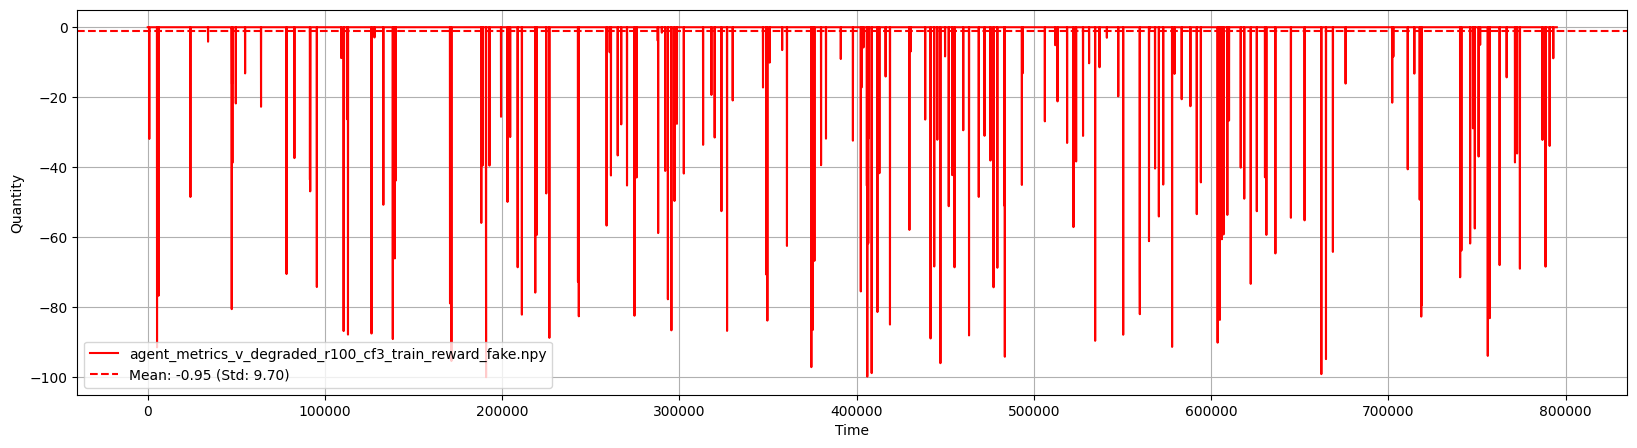

CPU times: user 481 ms, sys: 40 ms, total: 521 ms
Wall time: 892 ms


In [7]:
%%time

%run plot_evo.py agent_metrics_v_degraded_r100_cf3_train_reward_fake.npy --interpolation 10000

In [67]:
os.chdir("../")

# Tests

In [68]:
os.getcwd()

'/media/michael/Fichiers/Fac/Thèse 1/Code/Scripts'

In [69]:
import pandas as pd
import numpy as np
import os
import re
import geopandas as gpd
import random
from collections import defaultdict
from shapely.geometry import Point
from datetime import datetime, timedelta
from sklearn.neighbors import KDTree
import pickle
import argparse
from generate_environment import *

Z_1 = ['TOULOUSE - LOUGNON', 'TOULOUSE - VION']
Z_2 = ['ST JORY', 'ROUFFIAC', 'RAMONVILLE - BUCHENS', 'COLOMIERS', 'MURET - MASSAT']
Z_3 = ['AUTERIVE', 'ST LYS', 'GRENADE', 'FRONTON', 'VERFEIL', 'CARAMAN']

os.chdir('./Data')

# df_sorties = pd.read_csv("sorties_2018.csv", sep=";")
df_firestations = pd.read_csv("firestations.csv", sep = ';')
df_materiel = pd.read_csv("materiel_2018.csv", sep=";")
df_comp = pd.read_csv("comp_2018.csv", sep=";")
df_roles = pd.read_csv("roles_competences.csv", sep=";")
df_vehicles_history = pd.read_csv("df_vehicles_history.csv", sep=";")

df_xy = pd.read_csv("X-Y-lieu.csv", sep=";")
df_lieu = pd.read_csv("dbo.LIEU.csv", sep=";")
df_secteur = pd.read_csv("dbo.SECTEUR.csv", sep=";")
df_commune = pd.read_csv("dbo.COMMUNE.csv", sep=";")
df_nom_commune = pd.read_csv("dbo.NOM_COMMUNE.csv", sep=";")
df_responses = pd.read_csv("responses_by_incident.csv", sep = ';')
df_pdd = gpd.read_file("pdd.geojson")

df_stations = generate_stations(df_firestations)
stations_u = sorted(x for x in df_materiel['Nom du Centre'].unique() if not x.startswith('X') and not x.startswith('Z'))    
df_v = generate_vehicles(df_materiel, df_stations)    
df_skills, df_firefighters = generate_firefighters(df_comp)


os.chdir('../Data_environment')    

df_stations.to_pickle("df_stations.pkl")
df_v.to_pickle("df_v.pkl")
df_skills.to_pickle("df_skills.pkl")
df_roles.to_pickle("df_roles.pkl")
df_vehicles_history.to_pickle("df_vehicles_history.pkl")

os.chdir('../Data_preprocessed')

df_prob_dep = pd.read_pickle("df_prob_dep.pkl")
df_rank_incident = pd.read_pickle("df_rank_incident.pkl")

dic_inc_ar_mat = create_responses(df_responses, df_rank_incident)

# REAL

os.chdir('../Data_trained')

is_fake = False
df_pc_real = pd.read_pickle("df_real.pkl")
window = len(df_pc_real)
print("window real:", window)
df_pc_real = precompute_pdd(df_pdd, df_pc_real, stations_u)
df_pc_real = precompute_zone(df_stations, df_pc_real, Z_1, Z_2, Z_3)
df_pc_real = precompute_incident(df_rank_incident, df_pc_real)
df_pc_real = precompute_area_type(df_xy, df_lieu, df_nom_commune, df_commune, df_secteur, df_pc_real)

/tmp/ipykernel_58918/4149083117.py:23: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_materiel = pd.read_csv("materiel_2018.csv", sep=";")
/tmp/ipykernel_58918/4149083117.py:29: DtypeWarning: Columns (22,23,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lieu = pd.read_csv("dbo.LIEU.csv", sep=";")


window real: 53088


In [70]:
df_pc_real = pd.concat([df_pc_real, df_prob_dep], axis=1)
prob_dict = precompute_prob_dict(df_pc_real)
print("prob_dict computed")           
df_pc_real = precompute_prob_departure(df_pc_real, prob_dict)

prob_dict computed


In [71]:
start_year = 2018
start_inter = 1
end_inter = window

print("start_year", start_year, "start_inter", start_inter, "end_inter", end_inter)
    
df_pc_real = precompute_date(df_pc_real, start_year)
df_pc_real = precompute_returns(df_pc_real, start_inter, end_inter, is_fake)
print('real', len(df_pc_real), "done")

cols_to_norm = ["Coord X", "Coord Y", 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Hour_sin', 'Hour_cos']

for col in cols_to_norm:
    min_val = df_pc_real[col].min()
    max_val = df_pc_real[col].max()
    if min_val != max_val:
        df_pc_real[col] = (df_pc_real[col] - min_val) / (max_val - min_val)
    else:
        df_pc_real[col] = 0.0

os.chdir('../Data_environment')
df_pc_real.to_pickle("df_pc_real_prob.pkl")

start_year 2018 start_inter 1 end_inter 53088
362 197
Day
1      219
2      133
3      154
4      165
5      126
      ... 
361    106
362     86
363    130
364    131
365    138
Name: count, Length: 365, dtype: int64
real 106176 done


In [72]:
os.chdir('../Data_environment/')
df_p = pd.read_pickle("df_pc_real_prob.pkl")
df_p

,num_inter,date,PDD,departure,zone,Duration,Month,Day,Hour,Minute,Coord X,Coord Y,Month_sin,Month_cos,Day_sin,Day_cos,Hour_sin,Hour_cos
0,1,2018-01-01 00:05:00,"[TOULOUSE - VION, TOULOUSE - LOUGNON, COLOMIER...",{1: ['VSAV']},Z_1,54.0,1,1,0,5,0.919140,0.994960,0.75,0.933013,0.508607,0.999926,0.5,1.0
1,2,2018-01-01 00:12:00,"[MURET - MASSAT, ST LYS, RIEUMES, CARBONNE, TO...",{1: ['FPT']},Z_2,32.0,1,1,0,12,0.894974,0.992279,0.75,0.933013,0.508607,0.999926,0.5,1.0
2,3,2018-01-01 00:12:00,"[TOULOUSE - LOUGNON, TOULOUSE - VION, RAMONVIL...",{1: ['VSAV']},Z_1,25.0,1,1,0,12,0.920263,0.994755,0.75,0.933013,0.508607,0.999926,0.5,1.0
3,4,2018-01-01 00:12:00,"[FRONTON, VILLEMUR S/TARN, ST JORY, GRENADE, R...","{1: ['PSECSAP_EU'], 2: ['VSAV']}",Z_3,167.0,1,1,0,12,0.916107,0.998856,0.75,0.933013,0.508607,0.999926,0.5,1.0
4,5,2018-01-01 00:14:00,"[MURET - MASSAT, RAMONVILLE - BUCHENS, COLOMIE...",{1: ['VSAV']},Z_2,41.0,1,1,0,14,0.913199,0.992556,0.75,0.933013,0.508607,0.999926,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106171,53085,2019-01-01 01:06:00,[],{0: 'RETURN'},,0.0,1,1,1,6,0.000000,0.000000,0.50,0.500000,0.500000,0.499991,0.5,0.5
106172,53083,2019-01-01 01:19:00,[],{0: 'RETURN'},,0.0,1,1,1,19,0.000000,0.000000,0.50,0.500000,0.500000,0.499991,0.5,0.5
106173,53087,2019-01-01 01:19:00,[],{0: 'RETURN'},,0.0,1,1,1,19,0.000000,0.000000,0.50,0.500000,0.500000,0.499991,0.5,0.5
106174,53088,2019-01-01 01:30:00,[],{0: 'RETURN'},,0.0,1,1,1,30,0.000000,0.000000,0.50,0.500000,0.500000,0.499991,0.5,0.5


In [73]:
os.chdir('../')
from collective_functions import *

In [74]:
os.chdir('./Data_environment/')

In [75]:

df_p = pd.read_pickle("df_pc_real_prob.pkl")
date_reference = df_p.date.iloc[0]
df_skills = pd.read_pickle("df_skills.pkl")
df_roles = pd.read_pickle("df_roles.pkl")
df_vehicles_history = pd.read_pickle("df_vehicles_history.pkl")
dic_roles = create_dic_roles(df_vehicles_history)
dic_roles_skills = generate_dic_roles_skills(df_roles, df_skills)
skills_updated = update_skills(df_skills, date_reference)

def gen_ff_array(df_skills, skills_updated, ff_existing):
    return skills_updated[[df_skills.index.get_loc(matricule) for matricule in ff_existing]]
ff_existing = [9122, 9123, 9124, 9125, 9126, 9131, 9132, 9133, 9134, 9135]
ff_array = gen_ff_array(df_skills, skills_updated, ff_existing)    

In [76]:
ff_array

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 1]])

In [80]:
for idx, inter in df_p.iterrows():

    num_inter, date, pdd, required_departure, zone, duration, month, day, hour, minute, \
    coord_x, coord_y, month_sin, month_cos, day_sin, day_cos, hour_sin, hour_cos = inter
    if (required_departure != {0:"RETURN"}):
        veh_depart = [v[0] for k, v in sorted(required_departure.items())]

        state = np.hstack(([get_roles_for_ff(veh, ff_array, dic_roles, dic_roles_skills) for veh in veh_depart])).astype(float)
        state /= 8 # normalization, 8 skill lvls
            
        filler = np.zeros((80-state.shape[0], state.shape[1])) # max 74 de base + 6 ff lent
        state = np.vstack((state, filler))
    
        # filler col
        try:
            filler = np.zeros((state.shape[0], 37 - state.shape[1]))
            state = np.concatenate((state, filler), axis=1)
        except:
            print(num_inter, state.shape[1])
            break

4422 101


In [82]:
df_p.iloc[8829]["departure"]

{1: ['PSECINC'],
 2: ['VSAV'],
 3: ['VCG'],
 4: ['EPA'],
 5: ['FPT'],
 6: ['VSAV'],
 7: ['COMPL'],
 8: ['FPTL'],
 9: ['EPA'],
 10: ['VCG'],
 11: ['FPT'],
 12: ['VCG'],
 13: ['EPA'],
 14: ['FPT'],
 15: ['EPA'],
 16: ['PCC'],
 17: ['FPT'],
 18: ['VF'],
 19: ['CCF'],
 20: ['CCF'],
 21: ['FPT'],
 22: ['VCG'],
 23: ['VCG'],
 24: ['VF'],
 25: ['CCF'],
 26: ['VCG'],
 27: ['CCF'],
 28: ['VCG'],
 29: ['FPT'],
 30: ['VCG']}

In [89]:
prob_dict["AUTRES FEUX (SANS PRÉCISION)"]["URBAIN"]

{('FPTL',): 0.8200692041522492,
 ('FPTL', 'VSAV'): 0.0034602076124567475,
 ('FPTL',
  'EPA',
  'VCG',
  'VSAV',
  'VID',
  'FPTL',
  'FPT',
  'VSAV',
  'VID',
  'FPT',
  'VCG',
  'VSAV',
  'VID',
  'CCF'): 0.0034602076124567475,
 ('FPTL', 'EPA', 'VLHR', 'VCG', 'VID', 'FPT'): 0.0034602076124567475,
 ('FPTL', 'VSAV', 'VID', 'VCG', 'VID', 'VID', 'VCG'): 0.0034602076124567475,
 ('FPTL', 'EPA', 'VCG'): 0.006920415224913495,
 ('FPTL', 'CECGC'): 0.0034602076124567475,
 ('FPTL', 'VSR PROTEC'): 0.0034602076124567475,
 ('FPTL', 'VID'): 0.0034602076124567475,
 ('FPTL', 'VID', 'VSR PROTEC'): 0.0034602076124567475,
 ('FPT',): 0.01730103806228374,
 ('FPTL', 'FPT', 'VCG'): 0.0034602076124567475,
 ('VSAV', 'FPTL'): 0.0034602076124567475,
 ('FPTL', 'FMOGP', 'VCG'): 0.0034602076124567475,
 ('FPTL', 'FPT'): 0.01730103806228374,
 ('CCF',): 0.010380622837370242,
 ('FPTL', 'VCG'): 0.020761245674740483,
 ('FPTL', 'FPT', 'EPA', 'VCG'): 0.0034602076124567475,
 ('FPTL', 'EPA'): 0.0034602076124567475,
 ('FPTL', 

In [63]:
v_uniq = []

for inc, d1, in prob_dict.items():
    for area, d2 in d1.items():
        for tuple_v in d2.keys():
            for v in tuple_v:
                v_uniq.append(v)

v_uniq = sorted(set(v_uniq))

In [64]:
v_uniq

['BLS',
 'CCF',
 'CCF RECO',
 'CCFL2000',
 'CCFL500',
 'CCFM',
 'CCFS',
 'CCGC',
 'CEAR',
 'CECGC',
 'CEMUL',
 'COMPL',
 'COMPL CCF',
 'EPA',
 'EPC18',
 'FMOGP',
 'FPT',
 'FPT H INC',
 'FPT PROTEC',
 'FPT RAD',
 'FPT RCH',
 'FPTL',
 'FPTLHR',
 'FPTSR',
 'FPTSR PROT',
 'PCC',
 'PSECINC',
 'PSECINC2',
 'PSECSAP',
 'PSECSAP2',
 'PSECSAP_EU',
 'PSECSR',
 'ULTT',
 'VCG',
 'VEV',
 'VF',
 'VF4X4',
 'VGD',
 'VGELD',
 'VGRIMP',
 'VICH',
 'VID',
 'VID PROTEC',
 'VL',
 'VLD',
 'VLHR',
 'VLOSS',
 'VLTC',
 'VPCE',
 'VPCE SD',
 'VSAV',
 'VSAV 4X4',
 'VSM',
 'VSMP',
 'VSN',
 'VSR',
 'VSR PROTEC',
 'VTP',
 'VTU']

In [92]:
df_v_h['Type Matériel'] = df_v_h['Type Matériel'].fillna("")
df_v_h['Fonction'] = df_v_h['Fonction'].fillna("")
df_v_h['Type'] = df_v_h['Type'].fillna("")

In [93]:
for v in v_uniq:
    if v not in df_v_h['Type Matériel'].values:
        if v not in df_v_h['Fonction'].values:
            if v not in df_v_h['Type'].values:
                print(v)

In [44]:
df_v_h.columns

Index(['Identifiant unique du matériel', 'Classe Materiel', 'Famille Materiel',
       'Type Matériel', 'Fonction', 'Ordre de la fonction', 'Fonction Occupee',
       'Ordre Fonction Occupee', 'Obligatoire', 'Ordre', 'Piquet Simple',
       'Piquet Unique', 'Type'],
      dtype='object')

In [65]:
comp_sort = sorted(df_comp["Compétence - Nom"].dropna().unique())

In [66]:
li = sorted(["IMP3_CUNITE","IMP_CU", 
                   "IMP2_SAUV","IMP_SAUV", 
                   "COND_ENG_NAUT","COND_BMS_EB",
                    'CE_VLA',"*CE*",
                     'CHEF DE GROUPE',"*CDG*",
                     'CYN1_COND',"*CYN2*",
                     'CYN2_CUNITE',"*CYN3",
                     'EQ_VLA',"*EQ*",
                     'FDF_BD_EQ',"FDF_EQ",
                     'GELD_CU',
                     'GELD_EQ',
                     'INFIRMIER SP',
                     'INFIRMIER VLOSS',
                     'RAD1_EQ_RECO',
                     'RCH1_EQ_RECO',
                     'RCH2_EQ_INTER',
                     'SAL1_PLG',
                     'SAL2_PLG_CU',
                     'SAV1_SAUV',
                     'SMO1_EPIM',
                     'SMO2_EQ',
                     'SMO3_CUNITE',
                     'VLA_CE',"*CE*",
                     'VLA_EQ',"*EQ*"])

for e in li:
    if e not in comp_sort:
        print(e)

*CDG*
*CE*
*CE*
*CYN2*
*CYN3
*EQ*
*EQ*
CE_VLA
CHEF DE GROUPE
COND_BMS_EB
COND_ENG_NAUT
CYN1_COND
CYN2_CUNITE
EQ_VLA
IMP2_SAUV
IMP3_CUNITE
INFIRMIER SP
INFIRMIER VLOSS
RAD1_EQ_RECO
RCH1_EQ_RECO
RCH2_EQ_INTER
SAL1_PLG
SAL2_PLG_CU
SAV1_SAUV
SMO1_EPIM
SMO2_EQ
SMO3_CUNITE
VLA_CE
VLA_EQ


In [105]:
comp_sort

['***COD1',
 '***COD2',
 '***COD6',
 '***COND_',
 '***CO_AM',
 '***CO_EM',
 '***CO_PL',
 '***CO_TT',
 '***CO_VL',
 '***DRONE1',
 '***FO_TT',
 '***OP_NA',
 '***TR_S1',
 'CAN_CU',
 'CAN_EQ',
 'CA_1EQ_INC',
 'CA_DIV',
 'CA_INC',
 'CA_SAP',
 'CA_SR',
 'CDCENTRE',
 'CDCOLONNE',
 'CDGROUPE_DIV',
 'CDGROUPE_INC',
 'CDGROUPE_SAP',
 'CDSITE',
 'CEDEC_EQ',
 'CE_INC',
 'CHEF_CODIS',
 'COND_AMBULANCE',
 'COND_CT',
 'COND_EB',
 'COND_ECHELIER',
 'COND_EMB',
 'COND_ENG_POMPE',
 'COND_FORM_ENG_P',
 'COND_FORM_TT',
 'COND_PL_TT',
 'COND_SR',
 'COND_ULTT',
 'COND_VL_ROUTE',
 'COND_VL_TT',
 'COND_VSR',
 'CYN_COND',
 'CYN_CT',
 'CYN_CUNITE',
 'DDSIS',
 'DIRECTEUR ASTRT',
 'DRONE_CADREUR',
 'DRONE_CT',
 'DRONE_TELEPILOT',
 'EQ_DIV',
 'EQ_INC',
 'EQ_SAP',
 'EQ_SR',
 'FAE_CA',
 'FDF_BD_CC',
 'FDF_BD_EQ',
 'FDF_CA',
 'FDF_CDCOLONNE',
 'FDF_CDGROUPE',
 'FDF_CDSITE',
 'FDF_CT',
 'FDF_EQ',
 'GELD_CU',
 'GELD_EQ',
 'GREX_CU',
 'GREX_EQ',
 'GREX_INF',
 'GREX_MED',
 'IMP_CT',
 'IMP_CU',
 'IMP_EQ_SOL',
 'IMP_SAUV',

In [7]:
prob_dict

NameError: name 'prob_dict' is not defined

In [6]:
df = pd.read_pickle("df_pc_fake_10y_p12.pkl")

In [8]:
df["num_inter"].max()

np.int64(636960)

In [11]:
os.chdir("../")

In [2]:
import torch
import torch.nn as nn

# Paramètres
num_pompiers = 80
num_roles = 40
embedding_dim = 40  # chaque pompier est un vecteur de 40 dim

# Exemple d'entrée
X = torch.randn(num_pompiers, num_roles)  # shape: [80, 40]

# Reshape pour MultiheadAttention
# PyTorch attend : [sequence_len, batch_size, embedding_dim]
X_input = X.unsqueeze(1)  # [80, 1, 40]

# Mécanisme d'attention
attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=4, batch_first=False)

# Appliquer l'attention
# Q = K = V = X_input (self-attention)
attn_output, attn_weights = attn(X_input, X_input, X_input)  # output: [80, 1, 40]

# Résultat final : [80, 40]
output_matrix = attn_output.squeeze(1)


In [3]:
output_matrix

tensor([[ 0.0545, -0.0146,  0.0119,  ..., -0.0323,  0.0163, -0.0204],
        [ 0.0532, -0.0522, -0.0691,  ...,  0.0166,  0.0085, -0.0601],
        [ 0.0543,  0.0064, -0.0517,  ..., -0.0194, -0.0447, -0.0184],
        ...,
        [ 0.0196, -0.0718,  0.0128,  ..., -0.0358, -0.0213,  0.1020],
        [ 0.0657, -0.0525, -0.0922,  ..., -0.0304, -0.0697,  0.0479],
        [ 0.0433, -0.0536, -0.0339,  ..., -0.0574, -0.0191, -0.0140]],
       grad_fn=<SqueezeBackward1>)

In [6]:
from collective_functions import *
os.chdir('./Data_environment')

In [9]:


df_stations = pd.read_pickle("df_stations.pkl")

df_v = pd.read_pickle("df_v.pkl")
dic_vehicles, dic_functions = create_dic_vehicles(df_v)
dic_vehicles = purge_dic_v(dic_vehicles)


list_of_mats = dic_vehicles["TOULOUSE - VION"]["available"]
dic_vehicles["TOULOUSE - VION"]["available"] = constrain_veh(list_of_mats, 1)

list_of_mats = dic_vehicles["TOULOUSE - LOUGNON"]["available"]
dic_vehicles["TOULOUSE - LOUGNON"]["available"] = constrain_veh(list_of_mats, 1)

df_skills = pd.read_pickle("df_skills.pkl")

df_skills = df_skills.sample(len(df_skills)//1)

df_roles = pd.read_pickle("df_roles.pkl")
dic_roles_skills = generate_dic_roles_skills(df_roles, df_skills)

df_vehicles_history = pd.read_pickle("df_vehicles_history.pkl")
dic_roles = create_dic_roles(df_vehicles_history)

constraint factor veh is  1
constraint factor ff is  1 Number of ff: 3343


In [ ]:
list(dic_functions.keys())

In [ ]:
set(e for v in dic_functions.values() for e in v)

In [24]:
df_pc = df_pc = pd.read_pickle("df_pc_real.pkl")

In [25]:
old_date = df_pc.iloc[0, 1]
date_reference = df_pc.iloc[0, 1]
skills_updated = update_skills(df_skills, date_reference)

In [28]:
ff_existing = list(df_skills.index)

In [29]:
def gen_ff_array(df_skills, skills_updated, ff_existing):
    return skills_updated[[df_skills.index.get_loc(matricule) for matricule in ff_existing]]

skup = gen_ff_array(df_skills, skills_updated, ff_existing)

In [32]:
skup.shape

(3343, 134)

In [31]:
unique_rows = np.unique(skup, axis=0)
nb_unique = unique_rows.shape[0]
nb_unique

1368

In [ ]:
state = np.hstack(([get_roles_for_ff(veh, ff_array, dic_roles, dic_roles_skills) for veh in veh_depart])).astype(float)